In [77]:
#--------------------------------------------------------------------------------------
#
#     $Source: TestFlakiness/FindTestAddedBetweenIteration.py $
#
#  $Copyright: (c) 2018 Bentley Systems, Incorporated. All rights reserved. $
#
#--------------------------------------------------------------------------------------
import os
import csv
import sys
import sqlite3
import argparse
import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

#Common Scripts to be used by any task
# srcpath = os.getenv('SrcRoot')
# commonScriptsDir = os.path.join(srcpath, 'DgnDbTestingScripts', 'CommonTasks')
# sys.path.append(commonScriptsDir)
# dppath=os.path.join(*[srcpath,"DgnDbTestingScripts","TestFlakiness","TestsCatalog.db"])

import FindStream
from SqliteDatabase import Database


#-------------------------------------------------------------------------------------------
# bsimethod                                     Ridha.Malik                    07/2018
#-------------------------------------------------------------------------------------------
def StreamId(c,Stream):
    '''
        Retruns the stream Id from database
    '''
    c.execute("SELECT  StreamId FROM Stream WHERE name = ?",(Stream ,))
    result = c.fetchall()
    if len(result) != 0:
        id=result[0][0]
        return id
    else:
        print "Stream doesnot exists in testcatalog"
        exit (0)
#-------------------------------------------------------------------------------------------
# bsimethod                                     Ridha.Malik                    07/2018
#-------------------------------------------------------------------------------------------
def valid_date(s):
    try:
        return datetime.datetime.strptime(s, "%Y-%m-%d")
    except ValueError:
        msg = "Not a valid date its format YYYY-MM-DD should be: '{0}'.".format(s)
        raise argparse.ArgumentTypeError(msg)

# Temporarily assign variables that are to be taken from Command line

In [87]:
Stream = "bim0200"
StartDate="2018-01-01"
# StartDate=datetime.date.strftime(StartDate, "%Y-%m-%d")
EndDate="2018-07-03"
# EndDate=datetime.date.strftime(EndDate, "%Y-%m-%d") 

In [88]:
db=Database("TestsCatalog1.db")
db.connectDatabase()
c=db.cursor

streamid=StreamId(c,Stream)

# Divide the time frame into months

In [89]:
months = pd.date_range(start = StartDate, end = EndDate, periods=5, normalize=False).date

# Get the number of tests added before start date

In [90]:
streamid=StreamId(c,Stream)
sql = 'SELECT component, COUNT(*) FROM Tests where StreamId == ' + str(streamid) + ' AND Date <' + '\'' + StartDate + '\'' + 'GROUP BY component;'
c.execute(sql)
data=c.fetchall()
if len(data) == 0:
    print "No Test added prior to "+StartDate
df = pd.DataFrame.from_records(data, columns=['Component', 'Prior Count'])

In [91]:
df

,Component,Prior Count
0,BeHttp,216
1,BeSQLite,92
2,BeSecurity,25
3,Bentley,545
4,ConstructionSchema,30
5,DgnClientFx,379
6,DgnDisplay,33
7,DgnPlatform,566
8,DgnV8,183
9,Dwg,5


# Get the number of counts for each month untill EndDate and add that to the dataframe

In [92]:
for m in months:
    sql = 'SELECT component, COUNT(*) FROM Tests where StreamId == ' + str(streamid) + " AND Date <= '" + str(m) + "' GROUP BY component;"
    c.execute(sql)
    data=c.fetchall()
    df0 = pd.DataFrame.from_records(data, columns=['Component', 'Count'+str(m)])
    
    df = pd.merge(df, df0, on='Component', how='outer')
    df.fillna(0, inplace=True)

In [93]:
df

,Component,Prior Count,Count2018-01-01,Count2018-02-15,Count2018-04-02,Count2018-05-18,Count2018-07-03
0,BeHttp,216.0,216.0,247.0,261.0,272.0,272
1,BeSQLite,92.0,92.0,97.0,98.0,102.0,102
2,BeSecurity,25.0,25.0,25.0,25.0,25.0,25
3,Bentley,545.0,545.0,548.0,555.0,568.0,568
4,ConstructionSchema,30.0,30.0,30.0,30.0,30.0,30
5,DgnClientFx,379.0,379.0,384.0,389.0,389.0,389
6,DgnDisplay,33.0,33.0,37.0,37.0,37.0,37
7,DgnPlatform,566.0,566.0,569.0,583.0,589.0,615
8,DgnV8,183.0,183.0,190.0,196.0,202.0,205
9,Dwg,5.0,5.0,7.0,11.0,13.0,13


# Plot a line graph from start date till the end date

In [94]:
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette

cmap = plt.get_cmap('nipy_spectral')
colors = [cmap(i) for i in np.linspace(0, 1, len(df))]

[(1, 4, 8, 8, 10, 10, 14, 22, 23, 28, 39, 49, 56, 58, 103, 392, 450), (u'iModelBridge', u'DgnDisplay', u'Dwg', u'Units', u'BeSQLite', u'DgnClientFx', u'ComponentModeling', u'DgnV8', u'Bentley', u'GeoCoord', u'ECDb', u'DgnPlatform', u'BeHttp', u'ecobjects', u'GeomLibs', u'WSClient', u'ECPresentation')]


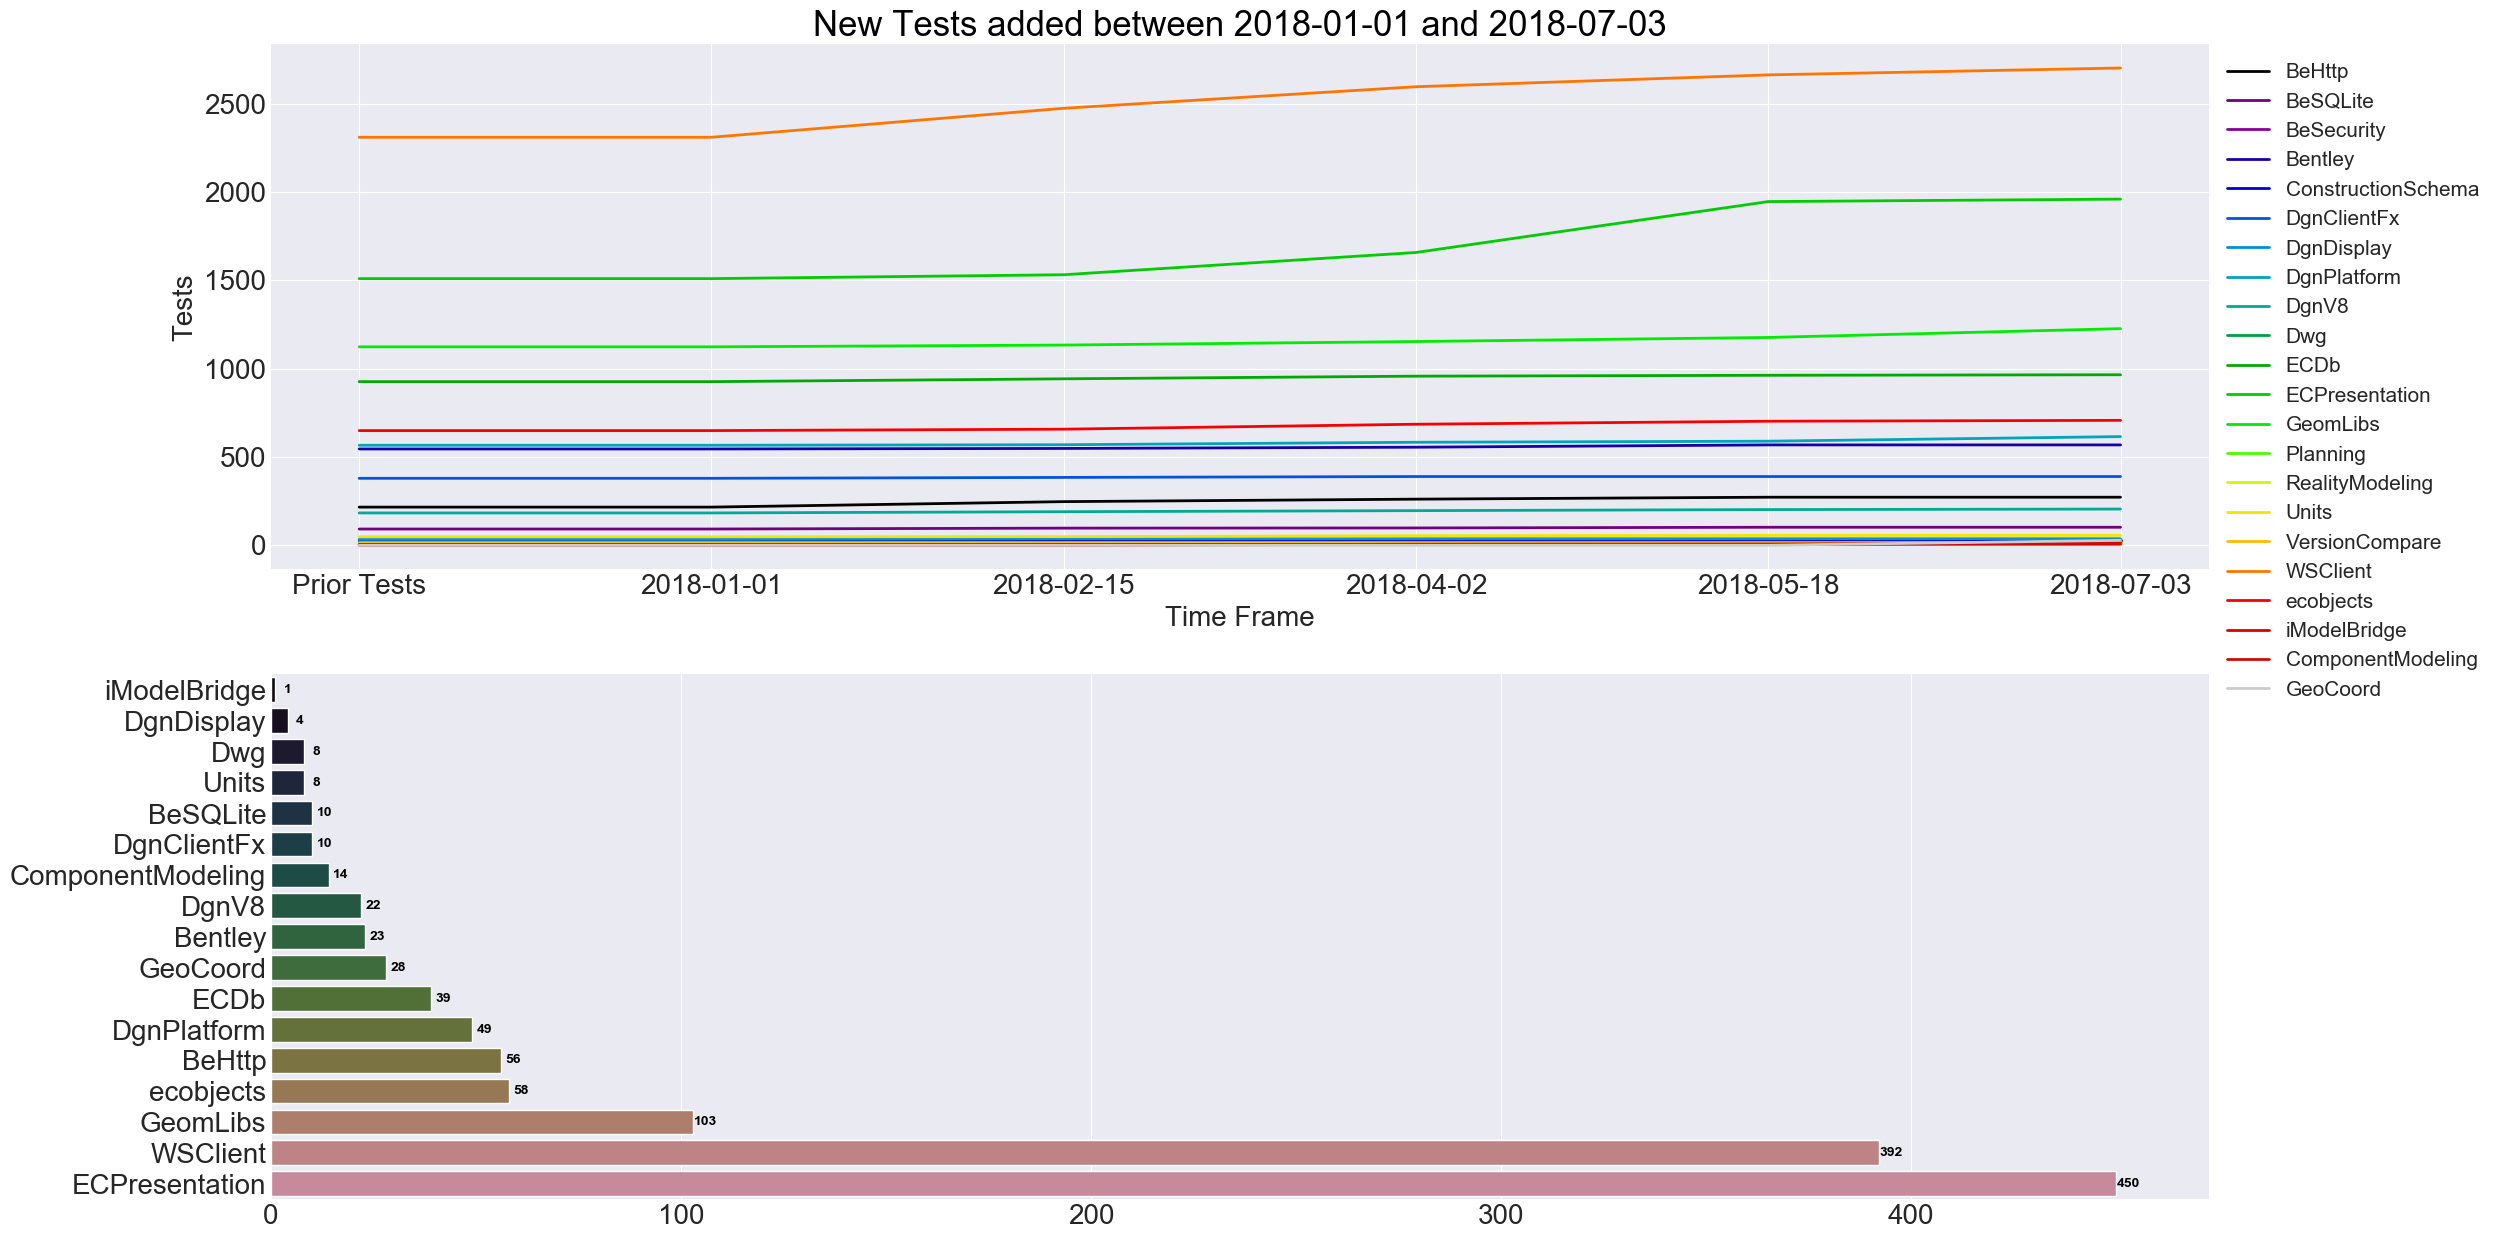

In [95]:
plt.figure(figsize=(25,15))
plt.subplot(2, 1, 1)

# multiple line plot
for i, row in df.iterrows():
#     print row
    plt.plot(row[1:], label = row[0], color = colors[i], linewidth = 2.0)
#     p.set_urls(['http://www.bbc.co.uk/news', 'http://www.google.com', None])

    # Add legend    
plt.legend(loc='upper left', ncol=1, fontsize=15, bbox_to_anchor=(1, 1))



# # Add titles
plt.title("New Tests added between "+StartDate+" and "+EndDate, fontsize=25, fontweight=0.5, color='Black')
plt.xlabel("Time Frame", fontsize=20)
plt.ylabel("Tests", fontsize=20)

x=['Prior Tests'] 
x.extend(months)

plt.xticks(np.arange(len(x)), x, fontsize=20)
plt.yticks(fontsize=20)


plt.subplot(2, 1, 2)







sql = 'SELECT TestId, TestCase, Test, Author, Component, Date FROM Tests where StreamId == ' + str(streamid) + " AND Date BETWEEN '"+StartDate+"' AND '"+EndDate+"'"
c.execute(sql)
data=c.fetchall()
if len(data) == 0:
    print "No Test added prior to "+StartDate
df1 = pd.DataFrame.from_records(data, columns=['TestId', 'TestCase', 'Test', 'Author', 'Component', 'Date'])


data = np.unique(df1.Component, return_counts=True)

sData = zip(*sorted(zip(data[1], data[0])))
Y, X = sData
X = np.array(X)
Y = np.array(Y)

print sData
size = np.shape(X)[0]

# fig = plt.figure(figsize=(size+5,size))
sns.set_style("whitegrid")

colors = sns.color_palette("cubehelix", len(df1.Component.unique()) + 10)

for i in range(size):
    g = sns.barplot(y=X[i:i+1], x=Y[i:i+1], color=colors[i], order = X, url = X[i]+'.svg', orient='h')
    g.text(Y[i] + 3, i + 0.1, Y[i], color='black', ha="center", weight="bold")


sns.despine(left=True)
g.tick_params(labelsize=20)
plt.savefig('Main2.png', dpi=300, orientation='landscape')
# plt.show()

[(1, 5, 8, 11, 12, 13, 14, 14, 17, 25, 28, 39, 77, 107, 139, 140, 174, 700, 1959), (u'ConstructionSchema', u'iModelBridge', u'Dwg', u'BeSQLite', u'DgnDisplay', u'VersionCompare', u'ComponentModeling', u'Units', u'DgnClientFx', u'Bentley', u'GeoCoord', u'DgnV8', u'DgnPlatform', u'BeHttp', u'ECDb', u'GeomLibs', u'ecobjects', u'WSClient', u'ECPresentation')]


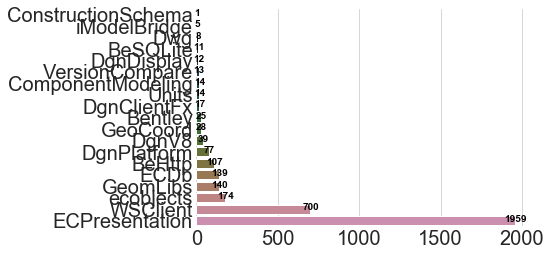

In [11]:
sql = 'SELECT TestId, TestCase, Test, Author, Component, Date FROM Tests where StreamId == ' + str(streamid) + " AND Date BETWEEN '"+StartDate+"' AND '"+EndDate+"'"
c.execute(sql)
data=c.fetchall()
if len(data) == 0:
    print "No Test added prior to "+StartDate
df1 = pd.DataFrame.from_records(data, columns=['TestId', 'TestCase', 'Test', 'Author', 'Component', 'Date'])

# df1

data = np.unique(df1.Component, return_counts=True)



sData = zip(*sorted(zip(data[1], data[0])))
Y, X = sData
X = np.array(X)
Y = np.array(Y)

print sData

size = np.shape(X)[0]

# fig = plt.figure(figsize=(size+5,size))
sns.set_style("whitegrid")

colors = sns.color_palette("cubehelix", len(df1.Component.unique()) + 10)

for i in range(size):
    g = sns.barplot(y=X[i:i+1], x=Y[i:i+1], color=colors[i], order = X, url = X[i]+'.svg', orient='h')
    g.text(Y[i] + 3, i + 0.1, Y[i], color='black', ha="center", weight="bold")


sns.despine(left=True)
g.tick_params(labelsize=20)
plt.savefig('Main2.svg', dpi=300, orientation='landscape')
plt.show()

# Chart for Unknown

In [21]:
sql = "SELECT Component, count(*) FROM Tests WHERE Author = 'UnKnown' and StreamId = "+str(streamid)+" and Date BETWEEN '"+StartDate+"' AND '"+EndDate+"' group by Component;"
c.execute(sql)
data=c.fetchall()
if len(data) == 0:
    print "No Test added prior to "+StartDate
df2 = pd.DataFrame.from_records(data, columns=['Component', 'Count'])


X = np.array(df2.Component)
Y = np.array(df2.Count)

size = np.shape(X)[0]


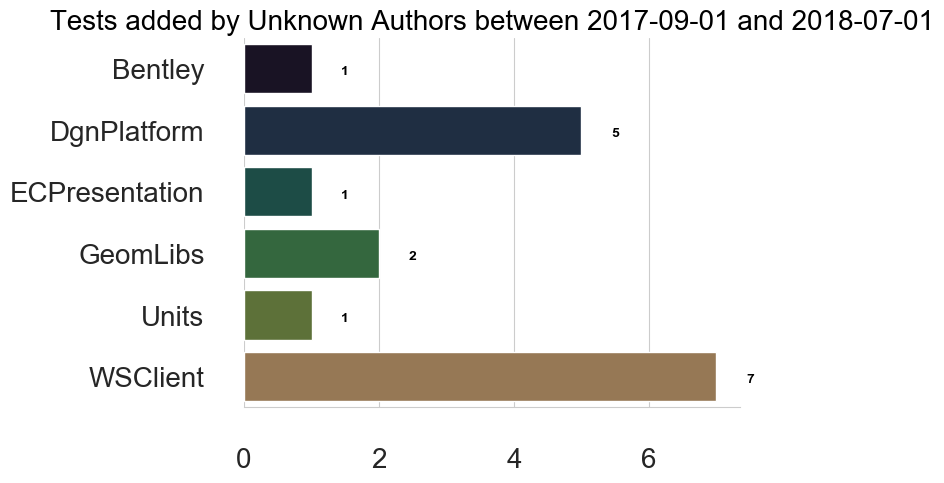

In [42]:
# fig = plt.figure(figsize=(size+5,size))

sns.reset_defaults()
plt.clf()
sns.set_style("whitegrid")

colors = sns.color_palette("cubehelix", len(df2.Component.unique()) + 5)

for i in range(size):
    g = sns.barplot(y=X[i:i+1], x=Y[i:i+1], color=colors[i], order = X, url = X[i]+'-unknown.html', orient='h')
    g.text(Y[i] + 0.5, i + 0.1, Y[i], color='black', ha="center", weight="bold")
    g.tick_params(labelsize=20)

sns.despine(left=True)

plt.title("Tests added by Unknown Authors between "+StartDate+" and "+EndDate, fontsize=20, fontweight=0.5, color='Black')
plt.savefig('Unknown.svg', dpi=300, orientation='landscape', bbox_inches="tight")

In [90]:
for i in range(size):
    sql = "SELECT TestCase, Test, Author, Component, Owner, File, Deleted, tag, Date FROM Tests WHERE  Author = 'UnKnown' and StreamId = "+str(streamid)+" and Component='"+X[i]+"' AND Date BETWEEN '"+StartDate+"' AND '"+EndDate+"';"
    c.execute(sql)
    data=c.fetchall()
    if len(data) == 0:
        print "Unable to get data fo unknown test "+X[i]
    df2 = pd.DataFrame.from_records(data, columns=['TestCase', 'Test', 'Author', 'Component', 'Owner', 'File', 'Deleted', 'tag', 'Date'])
#     print df2.columns
    table = PrettyTable(['TestCase', 'Test', 'Author', 'Component', 'Owner', 'File', 'Deleted', 'tag', 'Date'], border=True, header_style = 'title', padding_width =3)
    for j, row in df2.iterrows():
        table.add_row(row.values)
    
    html_file = open(X[i]+'-unknown.html','w')
    html_file.write(table.get_html_string())
    html_file.close()